In [300]:
import pandas as pd
import numpy as np
import seaborn as sns
import acessos as ac
import os 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [301]:
text_file = open(os.path.abspath('../Elasticidade CR - Simulações/sql/jan-mar-23.sql'), "r")
query = text_file.read()
text_file.close()
df = ac.df_athena_q('flavia-costa', query)

In [302]:
len(df)

132462

In [303]:
df.dt_mes_true.value_counts()

2023-01-01    48168
2023-02-01    43291
2023-03-01    41003
Name: dt_mes_true, dtype: int64

In [304]:
df.vl_compra_depois_60d.describe()

count    114037.000000
mean       1631.649511
std        2147.603613
min       -3270.430000
25%         480.810000
50%         980.470000
75%        1959.580000
max       60258.260000
Name: vl_compra_depois_60d, dtype: float64

In [305]:
missing_zero = ['qt_compra_antes_90d', 'vl_compra_antes_90d', 'vl_compra_depois_60d']

for column in missing_zero:
    df[column].fillna(0, inplace = True)

In [306]:
len(df.query('vl_compra_depois_60d == 0'))

18441

In [307]:
df[['hierarquia_1', 'cpf', 'dt_mes_true']].groupby(['hierarquia_1', 'dt_mes_true']).count()

cpf
hierarquia_1             dt_mes_true       
Assunto não identificado 2023-01-01     532
                         2023-02-01     595
                         2023-03-01    1116
Atendimento              2023-01-01     979
                         2023-02-01     832
                         2023-03-01     718
Cartão                   2023-01-01   27579
                         2023-02-01   29857
                         2023-03-01   27660
Conta                    2023-01-01    5173
                         2023-02-01    6780
                         2023-03-01    6600
Crédito Pessoal          2023-01-01     385
                         2023-02-01     264
                         2023-03-01     329
Fraude                   2023-01-01   11123
                         2023-02-01    2745
                         2023-03-01    2671
Marketing                2023-01-01      96
                         2023-02-01      45
                         2023-03-01      99
Marketplace              2023-01-01     112
                         2023-02-01     106
                         2023-03-01      74
Riscos 2 nivel           2023-01-01       1
Tecnologia               2023-01-01    2188
                         2023-02-01    2067
                         2023-03-01    1736

Criação de variáveis

In [308]:
df['dt_opening_account'] = pd.to_datetime(df['dt_opening_account'], format='%Y-%m-%d')
df['dt_mes_true'] = pd.to_datetime(df['dt_mes_true'], format='%Y-%m-%d')
df['cc_time'] = (df['dt_mes_true'] - df['dt_opening_account'])/ np.timedelta64(1, 'D')
    
df['dt_first_use_credit'] = pd.to_datetime(df['dt_first_use_credit'], format='%Y-%m-%d')
df['dias_ativacao'] = (df['dt_mes_true'] - df['dt_first_use_credit'])/ np.timedelta64(1, 'D')
    
df['dt_birth'] = pd.to_datetime(df['dt_birth'], format='%Y-%m-%d', errors = 'coerce')
df['age'] = (df['dt_mes_true'] - df['dt_birth']).astype('<m8[Y]')
    
df['dt_last_use_credit'] = pd.to_datetime(df['dt_last_use_credit'], format='%Y-%m-%d', errors = 'coerce')
df['dias_desde_ultima_compra'] = (df['dt_mes_true'] - df['dt_last_use_credit']).dt.days
   
df['vl_compra_antes_90d_log'] = np.log(df.vl_compra_antes_90d) #Ajuste da variável


In [309]:
df[['cc_time', 'vl_current_limit', 'dias_uso_app', 'vl_renda_declarada', 'dias_ativacao', 'qt_compra_antes_90d', 'dias_desde_ultima_compra', 'vl_compra_antes_90d']].describe()

,cc_time,vl_current_limit,dias_uso_app,vl_renda_declarada,dias_ativacao,qt_compra_antes_90d,dias_desde_ultima_compra,vl_compra_antes_90d
count,132434.000000,132462.000000,132462.000000,9.217700e+04,132462.000000,132462.00000,132462.000000,132462.000000
mean,586.124120,2773.502227,6.455851,1.888310e+04,551.041870,19.46602,14.703273,2169.248755
std,540.769797,3693.667994,11.219457,1.123475e+06,532.397933,22.22337,17.372465,2898.767490
min,-144.459373,0.000000,0.000000,0.000000e+00,-133.680637,1.00000,1.000000,0.050000
25%,146.533193,500.000000,0.000000,9.000000e+02,121.019384,5.00000,3.000000,562.215000
50%,384.344394,1400.000000,0.000000,1.800000e+03,346.531811,12.00000,8.000000,1255.095000
75%,928.275310,3100.000000,9.000000,3.000000e+03,867.577147,25.00000,19.000000,2660.390000
max,2111.876181,30000.000000,91.000000,9.198228e+07,2218.660000,747.00000,91.000000,89149.420000


In [310]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace = True)
    elif column == 'vl_compra_antes_90d_log':
        df[column].fillna(0, inplace = True)
    elif df[column].dtype != 'object':
        df[column].fillna(df[column].median(), inplace = True)

Função de normalização

In [311]:
def normalizando(x, var_min, var_max):
    y = (x - var_min) / (var_max - var_min)
    return y

In [312]:
df_n = pd.DataFrame()

df_n['cc_time'] = normalizando(df['cc_time'], 0.19, 2062.09)
df_n['vl_current_limit'] = normalizando(df['vl_current_limit'], 0, 12300)
df_n['dias_uso_app'] = normalizando(df['dias_uso_app'], 0, 35)
df_n['vl_renda_declarada'] = normalizando(df['vl_renda_declarada'], 0, 999999.99)
df_n['dias_ativacao'] = normalizando(df['dias_ativacao'], 0, 1812.25)
df_n['qt_compra_antes_90d'] = normalizando(df['qt_compra_antes_90d'], 1, 78)
df_n['dias_desde_ultima_compra'] = normalizando(df['dias_desde_ultima_compra'], 1, 77)


In [313]:
df_n[['cc_time', 'vl_current_limit', 'dias_uso_app', 'vl_renda_declarada', 'dias_ativacao', 'qt_compra_antes_90d', 'dias_desde_ultima_compra']].describe()

,cc_time,vl_current_limit,dias_uso_app,vl_renda_declarada,dias_ativacao,qt_compra_antes_90d,dias_desde_ultima_compra
count,132462.000000,132462.000000,132462.000000,132462.000000,132462.000000,132462.000000,132462.000000
mean,0.284151,0.225488,0.184453,0.013688,0.304065,0.239818,0.180306
std,0.262244,0.300298,0.320556,0.937224,0.293777,0.288615,0.228585
min,-0.070153,0.000000,0.000000,0.000000,-0.073765,0.000000,0.000000
25%,0.070980,0.040650,0.000000,0.001212,0.066779,0.051948,0.026316
50%,0.186311,0.113821,0.000000,0.001800,0.191216,0.142857,0.092105
75%,0.449587,0.252033,0.257143,0.002300,0.478729,0.311688,0.236842
max,1.024146,2.439024,2.600000,91.982282,1.224257,9.688312,1.184211


In [314]:
#Parametros modelo - regressão logística do estudo prévio
c_intercepto = -0.1635
c_usou_chat = -0.0655
c_flag_problema = -0.0993
c_vl_compra_antes_90d_log = 0.1318
c_cc_time = -0.6206
c_vl_current_limit = 0.3866
c_dias_uso_app = 0.2392
c_vl_renda_declarada = -5.3729
c_dias_ativacao = 0.3947
c_qt_compra_antes_90d = 0.2761
c_dias_desde_ultima_compra = -2.9933

queda_cr = 0.1

Atribuindo clientes sem atendimento

In [315]:
df['aleat'] = np.random.random((len(df),1))
df['usou_chat_sim'] = np.where(df.aleat <= (1 - queda_cr), 1, 0)
df['flag_problema_sim'] = np.where(df.usou_chat_sim == 0, 0, df.flag_problema )
df['teve_compra_depois'] = np.where(df.vl_compra_depois_60d > 0 , 1, 0)

In [316]:
df['rawPrediction'] = c_intercepto  + ((df.usou_chat_sim * c_usou_chat) + (df.flag_problema_sim * c_flag_problema) 
+ (df.vl_compra_antes_90d_log * c_vl_compra_antes_90d_log) 
+ (df_n.cc_time * c_cc_time)
+ (df_n.vl_current_limit * c_vl_current_limit) 
+ (df_n.dias_uso_app * c_dias_uso_app) 
+ (df_n.vl_renda_declarada * c_vl_renda_declarada) 
+ (df_n.dias_ativacao * c_dias_ativacao) 
+ (df_n.qt_compra_antes_90d * c_qt_compra_antes_90d)
+ (df_n.dias_desde_ultima_compra * c_dias_desde_ultima_compra))

df['score_compra_depois']  =  1/(1 + np.exp(-1 * df.rawPrediction))

In [317]:
df['score_compra_depois'].unique()

array([0.51627321, 0.67709657, 0.70155467, ..., 0.46716215, 0.09697556,
       0.6616393 ])

In [318]:
df['score_compra_depois'] = np.where(df['score_compra_depois'] < 0, 0, df['score_compra_depois'])
df['score_compra_depois'] = np.where(df['score_compra_depois'] > 1, 1, df['score_compra_depois'])

In [319]:
df[['rawPrediction', 'score_compra_depois']].describe()

,rawPrediction,score_compra_depois
count,132462.000000,1.324620e+05
mean,0.193618,5.663867e-01
std,5.101688,1.699913e-01
min,-493.494803,4.763544e-215
25%,-0.018486,4.953786e-01
50%,0.460279,6.130804e-01
75%,0.768402,6.831752e-01
max,3.613914,9.737609e-01


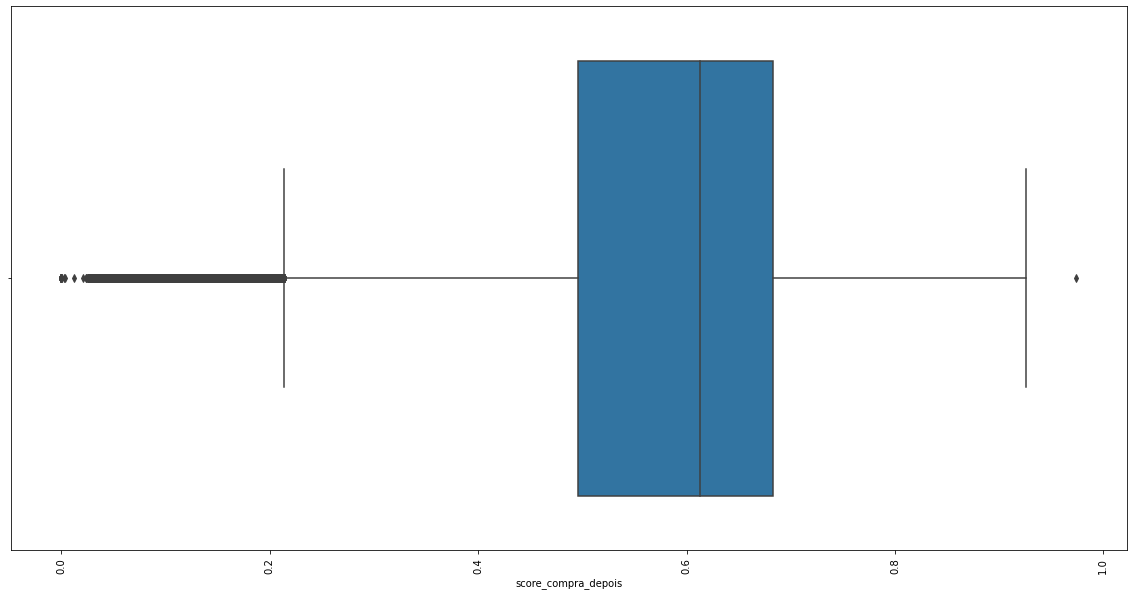

In [320]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df, x = 'score_compra_depois')
plt.xticks(rotation=90)
plt.show()

In [321]:
df['score_compra_depois'].max() - df['score_compra_depois'].min()

0.9737608797433462

In [322]:
df.teve_compra_depois.value_counts()

1    113914
0     18548
Name: teve_compra_depois, dtype: int64

In [324]:
len(df)

132462

In [326]:

df['fx_score'] = np.round(df['score_compra_depois'],1)


In [327]:
df[['teve_compra_depois', 'fx_score']].groupby('fx_score').mean()

,teve_compra_depois
fx_score,
0.0,0.391304
0.1,0.506524
0.2,0.623941
0.3,0.718819
0.4,0.779868
0.5,0.846649
0.6,0.891281
0.7,0.932689
0.8,0.952601


In [328]:
agg_df_compra_sim = df[df['teve_compra_depois'] == 1][['fx_score', 'cpf']].groupby('fx_score').count()
agg_df_compra_nao = df[df['teve_compra_depois'] == 0][['fx_score', 'cpf']].groupby('fx_score').count()

agg_df_compra = agg_df_compra_sim.join(agg_df_compra_nao, lsuffix='sim', rsuffix='nao')
agg_df_compra = agg_df_compra.reset_index()
agg_df_compra['cumperc_nao'] = agg_df_compra['cpfnao'].cumsum()/agg_df_compra['cpfnao'].sum()*100
agg_df_compra['cumperc_sim'] = agg_df_compra['cpfsim'].cumsum()/agg_df_compra['cpfsim'].sum()*100
agg_df_compra['dif'] = agg_df_compra['cumperc_nao'] - agg_df_compra['cumperc_sim']
agg_df_compra['dif_abs'] = np.abs(agg_df_compra['dif'])

In [329]:
# tabela de taxa de compra por fx-score para o ppt

agg_df_compra

,fx_score,cpfsim,cpfnao,cumperc_nao,cumperc_sim,dif,dif_abs
0,0.0,261,406.0,2.188915,0.229120,1.959795,1.959795
1,0.1,2368,2307.0,14.626914,2.307881,12.319033,12.319033
2,0.2,2872,1731.0,23.959457,4.829082,19.130375,19.130375
3,0.3,4530,1772.0,33.513047,8.805766,24.707281,24.707281
4,0.4,7546,2130.0,44.996765,15.430061,29.566704,29.566704
5,0.5,16182,2931.0,60.799008,29.635515,31.163493,31.163493
6,0.6,33817,4125.0,83.038603,59.321945,23.716658,23.716658
7,0.7,37620,2715.0,97.676299,92.346858,5.329441,5.329441
8,0.8,8441,420.0,99.940694,99.756834,0.183860,0.183860
9,0.9,276,11.0,100.000000,99.999122,0.000878,0.000878


In [330]:
#qtos clientes foram escolhidos ao acaso para não ter atendimento?

print(len(df.query('usou_chat_sim == 0')))

13279


In [340]:
print(len(df.query('usou_chat_sim == 0 & teve_compra_depois == 0')))

1893


In [331]:
# diferença de score entre clientes com e sem atendimento

df.groupby('usou_chat_sim')["score_compra_depois"].mean()

usou_chat_sim
0    0.586733
1    0.564120
Name: score_compra_depois, dtype: float64

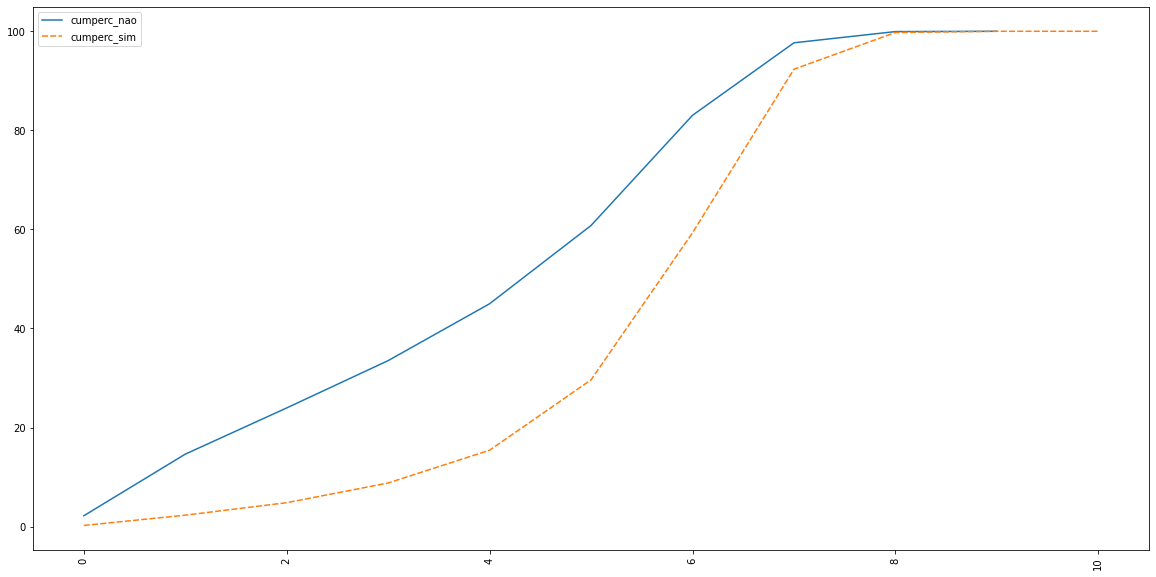

In [332]:
plt.figure(figsize = (20,10))
sns.lineplot(data = agg_df_compra[['cumperc_nao', 'cumperc_sim']])
plt.xticks(rotation=90)
plt.show()

In [333]:
dif_maxima = agg_df_compra['dif_abs'].max()

threshould_conservador = agg_df_compra[agg_df_compra.dif_abs == dif_maxima]['fx_score'].min()

print(threshould_conservador)

0.5


In [334]:
df['compra_depois_propensao']  = np.where(df['fx_score'] > threshould_conservador, 1,0)

print(len(df.query('compra_depois_propensao == 1')))
print(len(df.query('compra_depois_propensao == 0')))


87426
45036


In [335]:
#inputando spending para o cliente que teve churn de fato, que foi sorteado para não ter atendimento na simulação e com baixo score de compra depois
df['flag_atribui_spending'] = np.where((df['compra_depois_propensao'] == 1) & (df['teve_compra_depois'] == 0) & (df.usou_chat_sim == 0),1,0)

print(f"Temos {len(df.query('teve_compra_depois == 0 & usou_chat_sim == 0 & compra_depois_propensao == 0'))} clientes dentre os sorteados para não ter atendimento e não tiveram compra que tem ainda tem chance de churn (vou descartar)")

print(f"vou atribuir spending para {len(df.query('flag_atribui_spending == 1'))} clientes")

Temos 1037 clientes dentre os sorteados para não ter atendimento e não tiveram compra que tem ainda tem chance de churn (vou descartar)
vou atribuir spending para 856 clientes


In [336]:
df_comprou = df.query('teve_compra_depois == 1')

formula_text = ("""
vl_compra_depois_60d ~ 
C(periodo_depois30_fim) + 
qt_compra_antes_90d +  vl_current_limit + 
C(ds_gender) + C(ds_state_abbreviation) + C(ds_schooling) + 
C(ds_marital_status) + cc_time + dias_ativacao + 
C(ds_city_size) + vl_compra_antes_90d + vl_renda_declarada  + dias_uso_app
""")

model = ols(formula = formula_text, data = df_comprou).fit()
df_nao_comprou = df.query('flag_atribui_spending == 1')

print(len(df_nao_comprou))

for column in df_nao_comprou.columns:
    if df_nao_comprou[column].dtype == 'object':
        df_nao_comprou[column].fillna(df_nao_comprou[column].mode()[0], inplace = True)
    elif df_nao_comprou[column].dtype != 'object':
        df_nao_comprou[column].fillna(df_nao_comprou[column].median(), inplace = True)

prediction = model.predict(df_nao_comprou)

incremento_total = prediction.sum()

df_nao_comprou['valor incremental'] = prediction

resultado_sim = df_nao_comprou[['hierarquia_1', 'valor incremental', 'dt_mes_true']].groupby(['hierarquia_1', 'dt_mes_true']).sum()
resultado_sim = resultado_sim.reset_index()
resultado_sim

856


/tmp/ipykernel_354243/2554501543.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou[column].fillna(df_nao_comprou[column].mode()[0], inplace = True)
/tmp/ipykernel_354243/2554501543.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou[column].fillna(df_nao_comprou[column].median(), inplace = True)
/tmp/ipykernel_354243/2554501543.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou[column]

,hierarquia_1,dt_mes_true,valor incremental
0,Assunto não identificado,2023-01-01,4396.927193
1,Assunto não identificado,2023-02-01,2665.239571
2,Assunto não identificado,2023-03-01,18443.424715
3,Atendimento,2023-01-01,30855.216392
4,Atendimento,2023-02-01,769.121394
5,Atendimento,2023-03-01,9084.729165
6,Cartão,2023-01-01,331370.795474
7,Cartão,2023-02-01,360705.638086
8,Cartão,2023-03-01,369962.824562
9,Conta,2023-01-01,22071.398160


In [337]:
resultado_sim['valor incremental'].sum()

1531807.9577183945

In [338]:
resultado_sim.groupby('dt_mes_true')['valor incremental'].sum()

dt_mes_true
2023-01-01    545147.173523
2023-02-01    485572.521567
2023-03-01    501088.262629
Name: valor incremental, dtype: float64

In [348]:
sum((((prediction / 2) * 30)) * 0.0454)
# nos 3 meses

1043161.2192062255